In [1]:
# Run only once to install new version of solo_epd_loader
#%pip install --upgrade solo_epd_loader
#%pip install solo_epd_loader==0.2.8

In [2]:
from epd_plot_shift import *
from run_the_fit import *
from solo_epd_loader import calc_electrons

/home/annafed/anaconda3/envs/annamaria/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Notebook to plot and fit SolO EPD SEE data
#### General information about the notebook:
This Notebook allows the user to load, plot and fit SolO EPD SEE energy data.
The data loading process is done by using solo-epd-loader. 
<br>This package can be installed simply by running   %pip install git+https://github.com/jgieseler/solo-epd-loader    in any cell of the notebook. Note that this should only be done once. The package can be updated by running: %pip install git+https://github.com/jgieseler/solo-epd-loader --upgrade
<br>The data will be saved as cdf files to a local folder provided by the user. The data is then used to create dataframes of the electron data for each instrument and energy channel. 
<br>The flux data will be plotted as a timeseries. The timeseries include all the energy channels for each instrument. (add  expl pa) A flux peak will be searchered for each energy channel using the provided injection time and following the velocity dispersion. These values will then be plotted against the energy corresponding to the channels to form a spectrum. 
<br>The spectrum can then be fit with various functions to analyse its shape.


### NECESSARY INPUTS
Choose a folder where you wish to save the data from the loading, plotting and fitting process. 
If create_sub_folders = True, a new folder will be created for each event and the data etc will be saved there. 
<br> date : (datetime) format: datetime(yyyy, mm, dd, HH, MM) The date and approximate injection time of the event.

In [31]:
path =  r'/home/annafed/Documents/STIX_EPD_event_analysis/'
create_sub_folders = True
threshold_folders = False # if true saving to separate folders does not work. 
plot_n_data_folders = True
save_fit_run_variables_to_separate_folders = True

date = datetime(2020, 11, 17, 9, 42) #onset time or event ID inj time specified later
saving = True

position: this variable contains information about the location of SolO on the day of the event as well as the travel time of light and electrons with energy corresponding to the lowest STEP energy channel (4 keV) and the highest HET energy channel (10 MeV).

In [32]:
position = position_and_traveltime(date)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
-------------------------------------------  -----  --------
Distance of SolO from the Sun                [AU]    0.93
Length of the Parker Spiral for 400 km/s sw  [AU]    1.06005
Travel time of 4 KeV electrons               [min]  70.8719
Travel time of 10 MeV electrons              [min]   8.82661
Travel time of light                         [min]   7.73457
-------------------------------------------  -----  --------


### INPUTS FOR PLOTTING AND FITTING

Choose a viewing direction and time averaging for the data.
<br> __direction__ (string): 'sun', 'asun', 'north', 'south'    NOTE: STEP has 'sun' direction only. 
<br> __averaging__(str):  data averaging

<br> Possible values:
<br>‘W’
<br>‘D’ / ‘days’ / ‘day’
<br>‘hours’ / ‘hour’ / ‘hr’ / ‘h’
<br>‘m’ / ‘minute’ / ‘min’ / ‘minutes’ / ‘T’
<br>‘S’ / ‘seconds’ / ‘sec’ / ‘second’
<br>‘ms’ / ‘milliseconds’ / ‘millisecond’ / ‘milli’ / ‘millis’ / ‘L’
<br>‘us’ / ‘microseconds’ / ‘microsecond’ / ‘micro’ / ‘micros’ / ‘U’
<br>‘ns’ / ‘nanoseconds’ / ‘nano’ / ‘nanos’ / ‘nanosecond’ / ‘N’

<br> __ion_correction__ (bool): if True will use ion corrected EPT data (use only if inclusing EPT data)
<br> __bg_subtraction__ (bool): if True will use background subtracted data (else choose False)
<br> __step__ (bool): if True step data will be dowloaded and plotted
<br> __ept__ (bool): if True ept data will be dowloaded and plotted
<br> __het__ (bool): if True het data will be dowloaded and plotted
<br> __fit_type__ (string): the combination of instriment data that will be fit. Options: 'step', 'ept', 'het', 'step_ept', 'ept_het', 'step_ept_het'
<br> __which_fit__ (string): the type of pl function that will be fit to the data. Note that if the data cannot be fit with a specific function the software will choose the next best option. Options: 
<br> __'single'__ will force a single pl fit to the data.
<br> __'broken'__ will force a broken pl fit to the data but ONLY if the break point is within the energy range otherwise a sigle pl fit will be produced instead.
<br> __'best_sb'__ will choose automatically the best fit type between single and broken by comparing the redchis of the fits.
<br> __'cut'__ will produce a single pl fit with an exponential cutoff point. If the cutoff point is outside of the energy range a broken or single pl will be fit instead.
<br> __'broken_cut'__ will produce a broken pl fit with an exponential cutoff point. If the cutoff point is outside of the energy range a broken, cut or single pl will be fit instead.
<br> __'best_cb'__ will choose automatically the best fit type between broken and cut by comparing the redchis of the fits. A single pl will be fit to the data if the other fits are not physical. 
<br> __'triple'__ will try to fit a triple pl to the data. If this is not possible, the next best option will be fit to the data. 
<br> __'best'__ will automatically choose the best out of all the fitting options.

In [78]:
direction = 'sun'
averaging = '1min'
contamination_threshold = 0  # either None or an integer >0 (STEP)

ion_correction = True 
bg_subtraction = True

step = True
ept = True
het = True

fit_type= 'step_ept'
which_fit = 'broken'


### NON-NECESSARY INPUTS

#### PLOTTING TIMESERIES AND SPECTRUM (NO FIT)
The following inputs can be changed, but the notebook will run without any furher changes.
<br> __start_date__ and __end_date__ (int or datetime): The start and end date to download data. These should be different only in case the event occurs close to midnight. Automatically done if the event is less that 4h from midnight. Format: datetime(yyyy, mm, dd) or yyyymmdd.
<br> __plot_start__ and __plot_end__ (string): The start and end time for the timeseries plot. Automatically taken as $\pm$4h. Format: 'yyyy-mm-dd-HHMM'
<br> __t_inj__ (string): taken automatically from previously defined value (date). Also this value is changed by using the light travel time (position) to fit the peak into the search window. This value is fixed to the highest HET channel (close traveltime to light tt for electrons), the rest of the window times are calculated using velocity dispersion.
<br> For the background there are two options: either a fixed bg window that starts and ends at the same time for each energy channel or a bg window that follows the peak search window (beacuse of velocity dispersion at different times for different energy channels). 
For a fixed bg window: __bg_start__ and __bg_end__ (string, defaults to None) 'yyyy-mm-dd-HHMM'
For a bg window that follows the peaxk search window: __bg_distance from window__ (int, defauts to 120): the distance of the start time of the bg window from the start of the search window in minutes. __bg_period__ (int, defaults to 60) the length of the bg window in minutes.
<br> __travel_distance__ (float): Length of the Parker Spiral in AU. This is taken automatically from the position variable.
<br> __travel_distance_second_slope__ (float, defaults to None): __travel_distance_second_slope__ > __travel_distance__ If specified this will create a peak search window that broadens at lower energies. If specified set fixed_window = None.
<br> __fixed_window__ (int, defauts to 60): the length of the search window in minutes. 
<br> __autodownload__ (bool, defaults to True): If True will automatically download the data to analyse the event.
<br> __data_type__ (string, defaults to 'l2'): 'll' = low latency, 'l1' = level 1 data, 'l2' = level 2 data for scientific research.
<br> __plot_pa__ (bool, defauts to True): plots the pitch angle coverage for the event.

In [95]:
start_date = date.date()
enddate = date+timedelta(hours = 6)
end_date = enddate.date()

plot_start = str(date-timedelta(hours = 8))[:-3].replace(' ', '-').replace(':', '')
plot_end = str(date+timedelta(hours = 6))[:-3].replace(' ', '-').replace(':', '')


t_inj = str(date)[:-3].replace(' ', '-').replace(':', '')
date_folder = t_inj
#plot_path = path_to_folder
#if create_sub_folders:
#  create_new_path(path, t_inj)#, threshold_folders = threshold_folders, contamination_threshold = contamination_threshold, plots_n_data = plot_n_data_folders)
#  path_to_folder = path+t_inj+'/'
# plot_path = path_to_folder

if contamination_threshold == None:
    threshold_folders = False
if create_sub_folders:
    create_new_path(path, t_inj, threshold_folders = threshold_folders, contamination_threshold = contamination_threshold, plots_n_data = plot_n_data_folders)
    path_to_folder = path+t_inj+'/'
    plot_path = path_to_folder
if threshold_folders:
    path_to_folder = path_to_folder+'contamination_threshold_'+str(contamination_threshold)+'/'
if plot_n_data_folders:
    plot_path = path_to_folder+'plots'
 
    
# Need to subtract the light travel time at SolO distance because the Raul inj. times
# in the STIX/EPD table are shifted from sun to SolO and I need inj. time at the Sun
#t_inj = str(date-timedelta(minutes = position[4][2]))[:-3].replace(' ', '-').replace(':', '')
t_inj = str(date-timedelta(minutes = 20))[:-3].replace(' ', '-').replace(':', '')

print(date_folder)

bg_start = None 
bg_end = None 
bg_distance_from_window = '10min'
bg_period = '3h'

travel_distance = position[0][2]
travel_distance_second_slope = None
fixed_window = '60min' #either input time period in minutes or None

autodownload_data = True
data_type = 'l2'
plot_pa = True


Creating new directory /home/annafed/Documents/STIX_EPD_event_analysis/2020-11-17-0942
2020-11-17-0942


#### INPUTS FOR THE FIT
<br> __c1_guess__ (int or float, defaults to 1000): the flux value corresponding to 0.1 MeV
<br> __g1_guess__ (int or float, defaults to -1.9): the slope of a single pl or the first part of a broken or triple pl. __g1_guess__ > __g2_guess__, __g3_guess__ and __g1_guess__< 0.
<br> __g2_guess__ (int or float, defaults to -2.5): the slope of the broken pl after the break or the slope between the two breaks for a triple pl. __g1_guess__> __g2_guess__ >  __g3_guess__ and __g2_guess__< 0.
<br> __g3_guess__ (int or float, defaults to -4): the slope of a triple pl after the second break. __g1_guess__, __g2_guess__ >  __g3_guess__ and __g3_guess__< 0.
<br> __alpha_guess__ and __beta_guess__ (int or float, defaults to 10): the smoothness of the first and second break respectively.
<br> __break_guess_low__ (int or float, defaults to 0.6 MeV): the energy corresponding to the first break in the spectrum (in MeV).
<br>__break_guess_high__ (int or float, defaults to 1.2 MeV): the energy corresponding to the second break in the spectrum (in MeV).
<br> __cut_guess__ (int or float, defaults to 1.2 MeV): the energy corresponding to the exponential cutoff in the spectrum (in MeV).
<br> __fit_to__ (string, defaults to 'peak'): 'peak' or 'average'
<br> __e_min__ and __e_max__ (int or float, defaults to None): minimum and maximum energy to fit. If None will automatically be taken as min and max fittable values. step energy range: 0.004323343613-0.07803193193 MeV, ept energy range: 0.03295087252-0.452730295 MeV, het energy range: 0.6859485403-10.62300288 MeV, second het channel: 1.590048112 MeV
<br> __use_random__ (bool, defaults to True): if True the software will choose random values close to the guess values that will be fit to the data to find the fit with the lowest redchisq.
<br> __random_iterations__ (int, defaults to 20): number of times the random values will be chosen.
<br> __sigma__ (int, defaults to 3.): standard deviation from the background.
<br> __rel_err__ (float, defaults to 0.5): The absolute value of the uncertainty of the bg subtracted flux peak divided by the bg subtracted peak.
<br> __frac_nan_threshold__ (float, defaults to 0.9): exclude all spectrum values with fraction of non-nan data points in search window lower than the corresponding value.
<br> __leave_out_1st_het_chan__ (bool, defaults to True): If True, the first HET channel will be left out from the fit.
<br> __shift_step_data__ (bool, defaults to False): If True, STEP data will be shifted (up or down, intensity wise) by a factor equal to shift_factor.
<br> __shift_factor__ (float, defaults to None): Factor to shift STEP data (e.g. 0.8). 
<br> __legend_details__ (bool, optional): If True, the final fit type and the reduced chi square will be dislayed in the legend.
	


In [88]:
c1_guess = 1000
g1_guess = -1.9
g2_guess = -2.5
g3_guess = -4
alpha_guess = 10
beta_guess = 10
break_guess_low = 0.6
break_guess_high = 1.2
cut_guess = 1.2

fit_to = 'peak'

e_min = None
e_max = None

use_random = True
random_iterations = 20

if saving:
    save_fig = True
    save_fit_variables = True
    save_fitrun = True

sigma = 3
rel_err = 0.5
frac_nan_threshold = 0.9
leave_out_1st_het_chan = False
shift_step_data = False
shift_factor = None #0.8

detailed_legend = True

## LOAD DATA

In [89]:
if plot_pa:
    msdate = dt.datetime.combine(pd.to_datetime(plot_start).date(), dt.time.min)
    medate = dt.datetime.combine(pd.to_datetime(plot_end).date()+ dt.timedelta(days=1), dt.time.min) #+ dt.timedelta(days=1)

    mag_srf = solo_mag_loader(msdate, medate, level='l2', frame='srf', av=None, path=path_to_folder)
    

Loading MAG...


In [90]:
if step:   
    # read in STEP original data to df_particles_step_org. electron fluxes calculated later with calc_electrons
    df_particles_step_org, energies_step = epd_load(sensor='step', level='l2', startdate=start_date, 
                                                    enddate=end_date, path=path_to_folder, autodownload=True, 
                                                    only_averages=True)

Loading /home/annafed/Documents/STIX_EPD_event_analysis/2020-11-17-0942/l2/epd/step/solo_L2_epd-step-rates_20201117_V02.cdf


In [91]:
#df_particles_step

In [92]:
if ept:
    df_protons_ept, df_electrons_ept, energies_ept = epd_load(sensor = 'ept', viewing = direction, level = 'l2',
                                                                  startdate = start_date, enddate = end_date, 
                                                                  path=path_to_folder, autodownload=True)
    

In [93]:
if het:  
    df_protons_het, df_electrons_het, energies_het = epd_load(sensor = 'het', viewing = direction, level = 'l2',
                                                            startdate = start_date, enddate = end_date, 
                                                            path=path_to_folder, autodownload=True)
   

In [ ]:
# change depending on onset time difference 
t_inj = str(date-timedelta(minutes = 20))[:-3].replace(' ', '-').replace(':', '')


## STEP

contamination_threshold has been set to 0. Ignoring the contamination_threshold (i.e., NOT calculating it for 0)!


/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:815: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_electron_uncertainties['Electron_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')


Calculating PA coverage for step...
Opening of STEP just a placeholder! Replace with real value! This affects the 'min' and 'max' values of the pitch-angle, not the 'center' ones.


100%|██████████| 2880/2880 [00:01<00:00, 2776.03it/s]


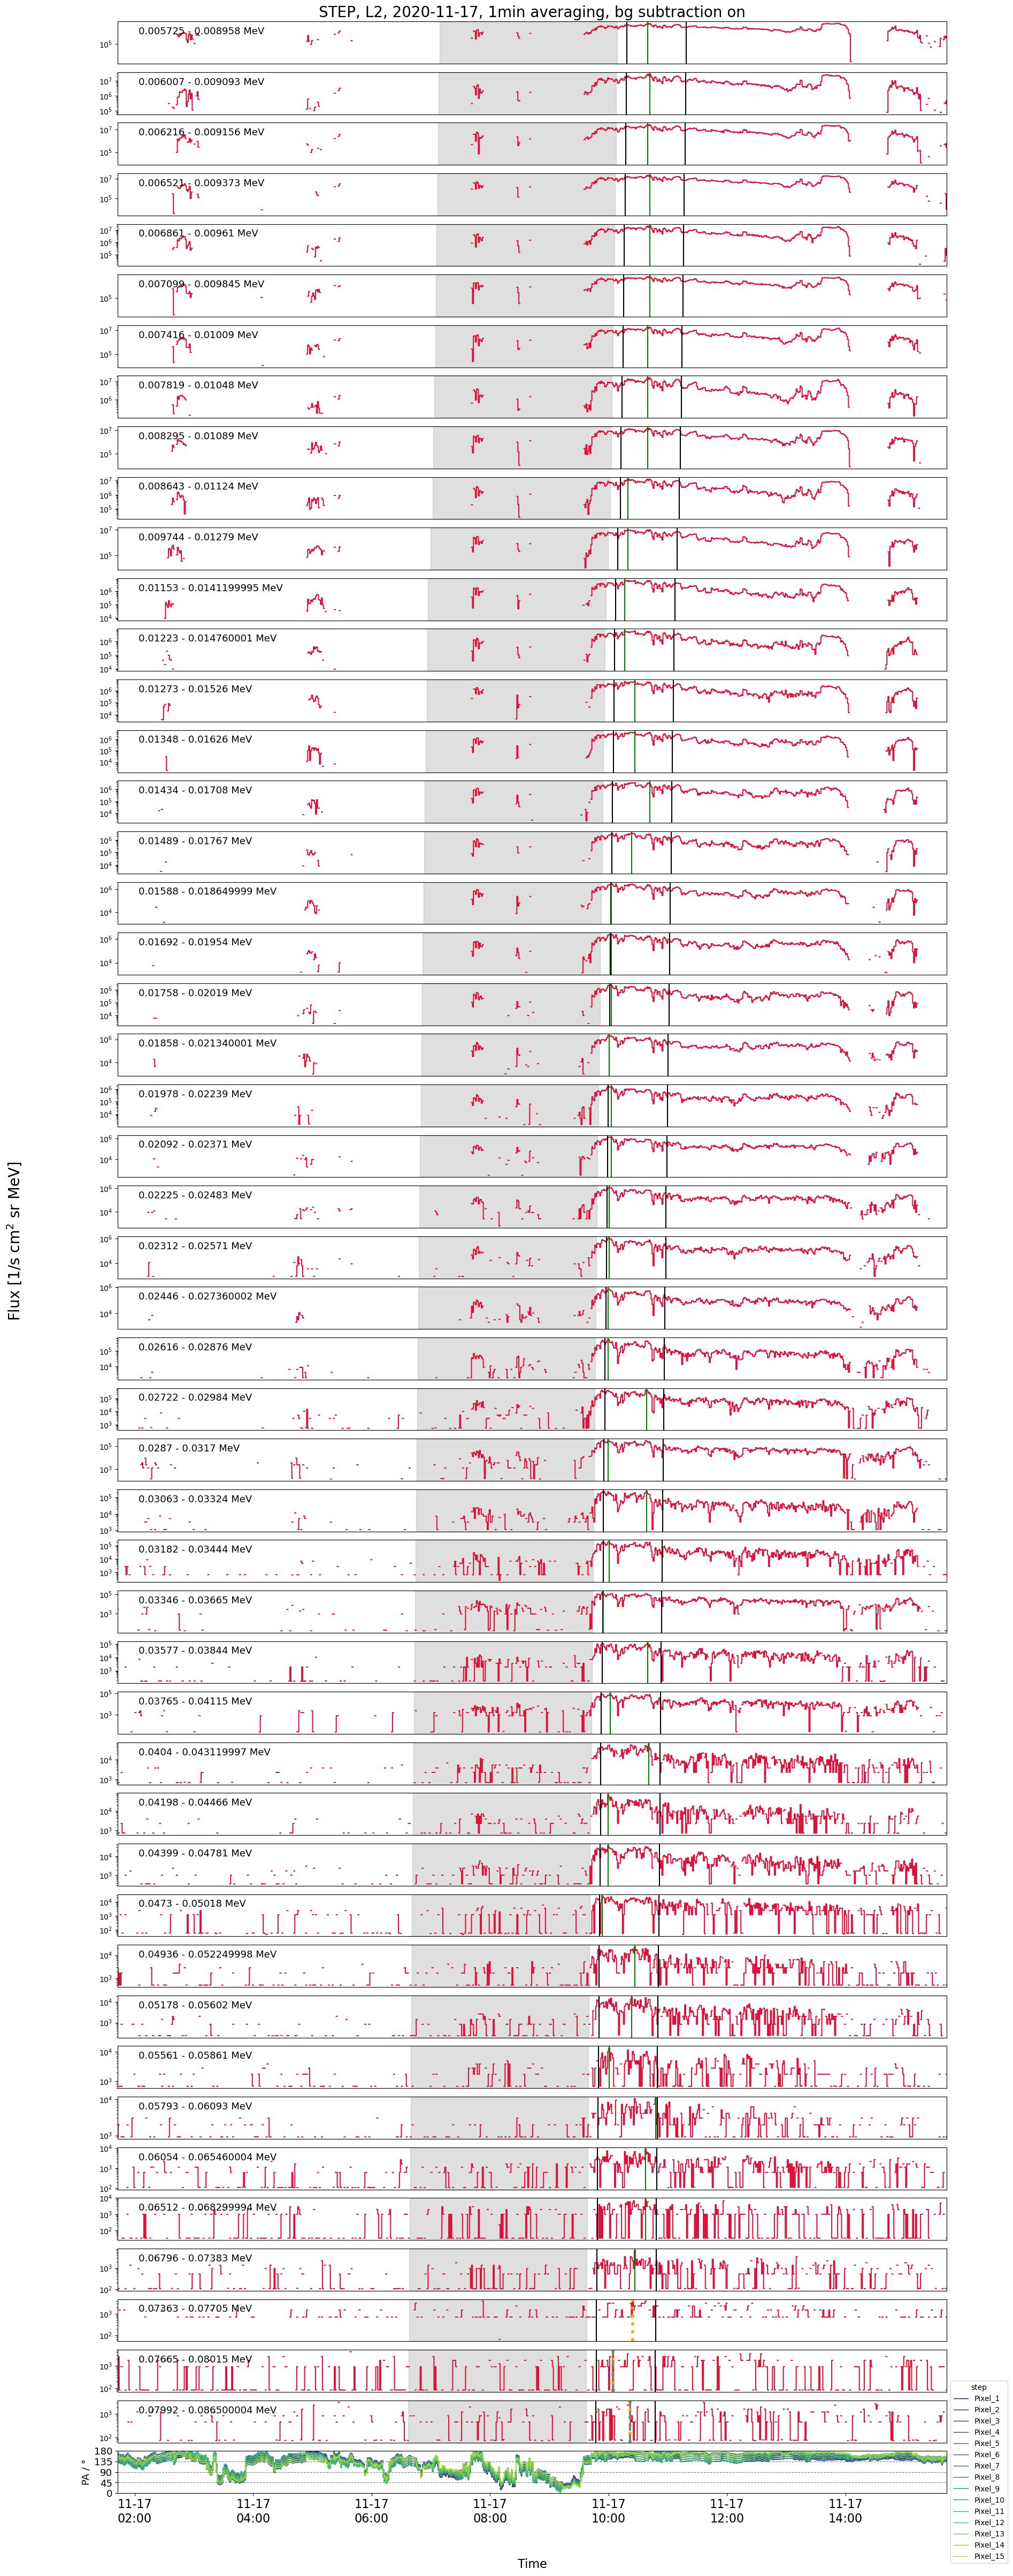

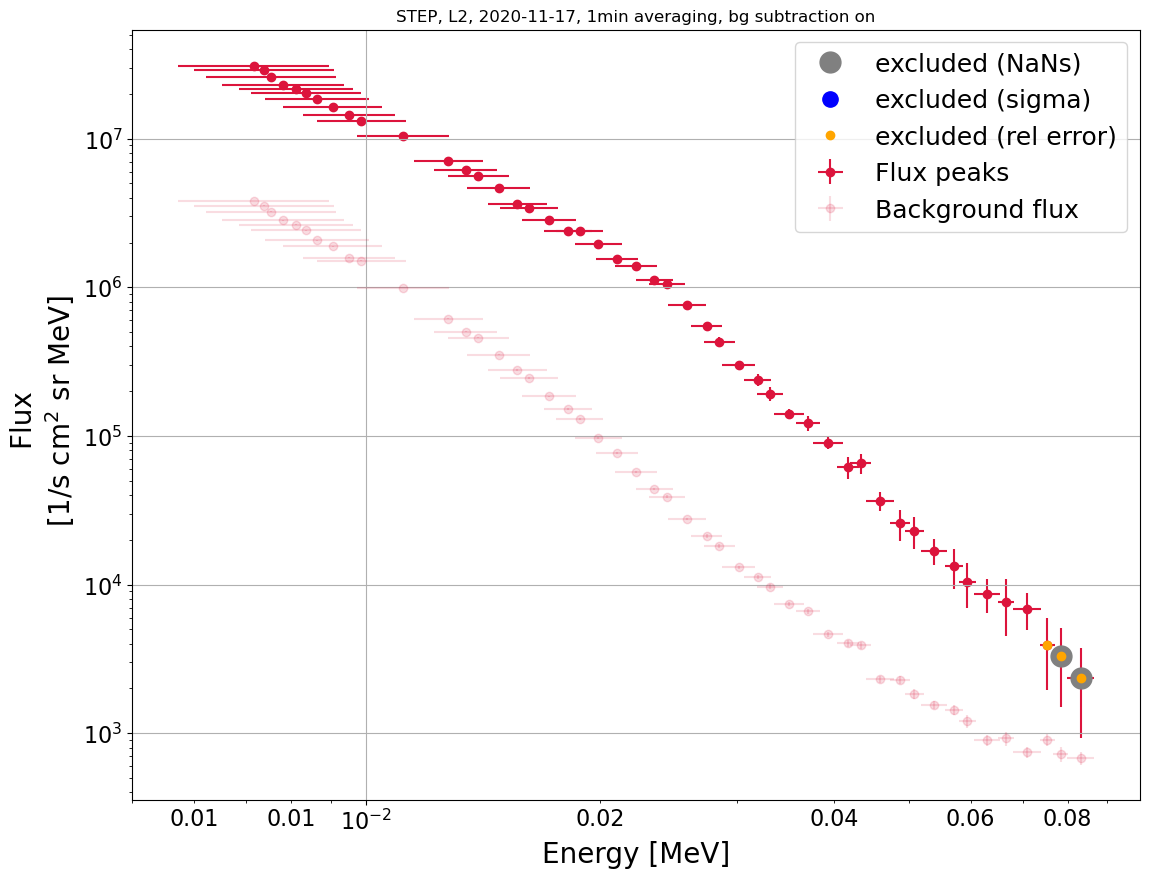

In [96]:
if step:
    # calculate resampled STEP electron fluxes (+ ions)
    df_particles_step = calc_electrons(df=df_particles_step_org, meta=energies_step, 
                                       contamination_threshold=contamination_threshold, only_averages=True,
                                       resample=averaging)
    data_step = extract_electron_data(df_particles_step, energies_step, plot_start, plot_end, t_inj, 
                                      bgstart = bg_start , bgend = bg_end, bg_distance_from_window = bg_distance_from_window, 
                                      bg_period = bg_period, travel_distance = travel_distance, 
                                      travel_distance_second_slope = travel_distance_second_slope, fixed_window = fixed_window, 
                                      instrument = 'step', data_type = 'l2', averaging=averaging, 
                                      masking=False)
    if plot_pa:
        if averaging is not None:
            mag_srf = mag_srf.resample(averaging).mean()
        coverage = calc_pa_coverage('step', mag_srf)

    if saving: write_to_csv(data_step, path=path_to_folder)
    bg_b = bg_subtraction
    plot_channels(data_step, bg_subtraction=bg_b, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'step', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err)
    bg_b = bg_subtraction
    plot_spectrum_peak(data_step, bg_subtraction=bg_b, path=plot_path, savefig=saving, sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold= rel_err, direction = direction)
    #plot_spectrum_average(data_step, bg_subtraction=bg_b, savefig=saving, path=path_to_folder, sigma=sigma, frac_nan_threshold=frac_nan_threshold, rel_err_threshold=rel_err, direction=direction)
    


## EPT

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:815: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_electron_uncertainties['Electron_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')


Calculating PA coverage for ept...


100%|██████████| 576/576 [00:00<00:00, 11071.23it/s]


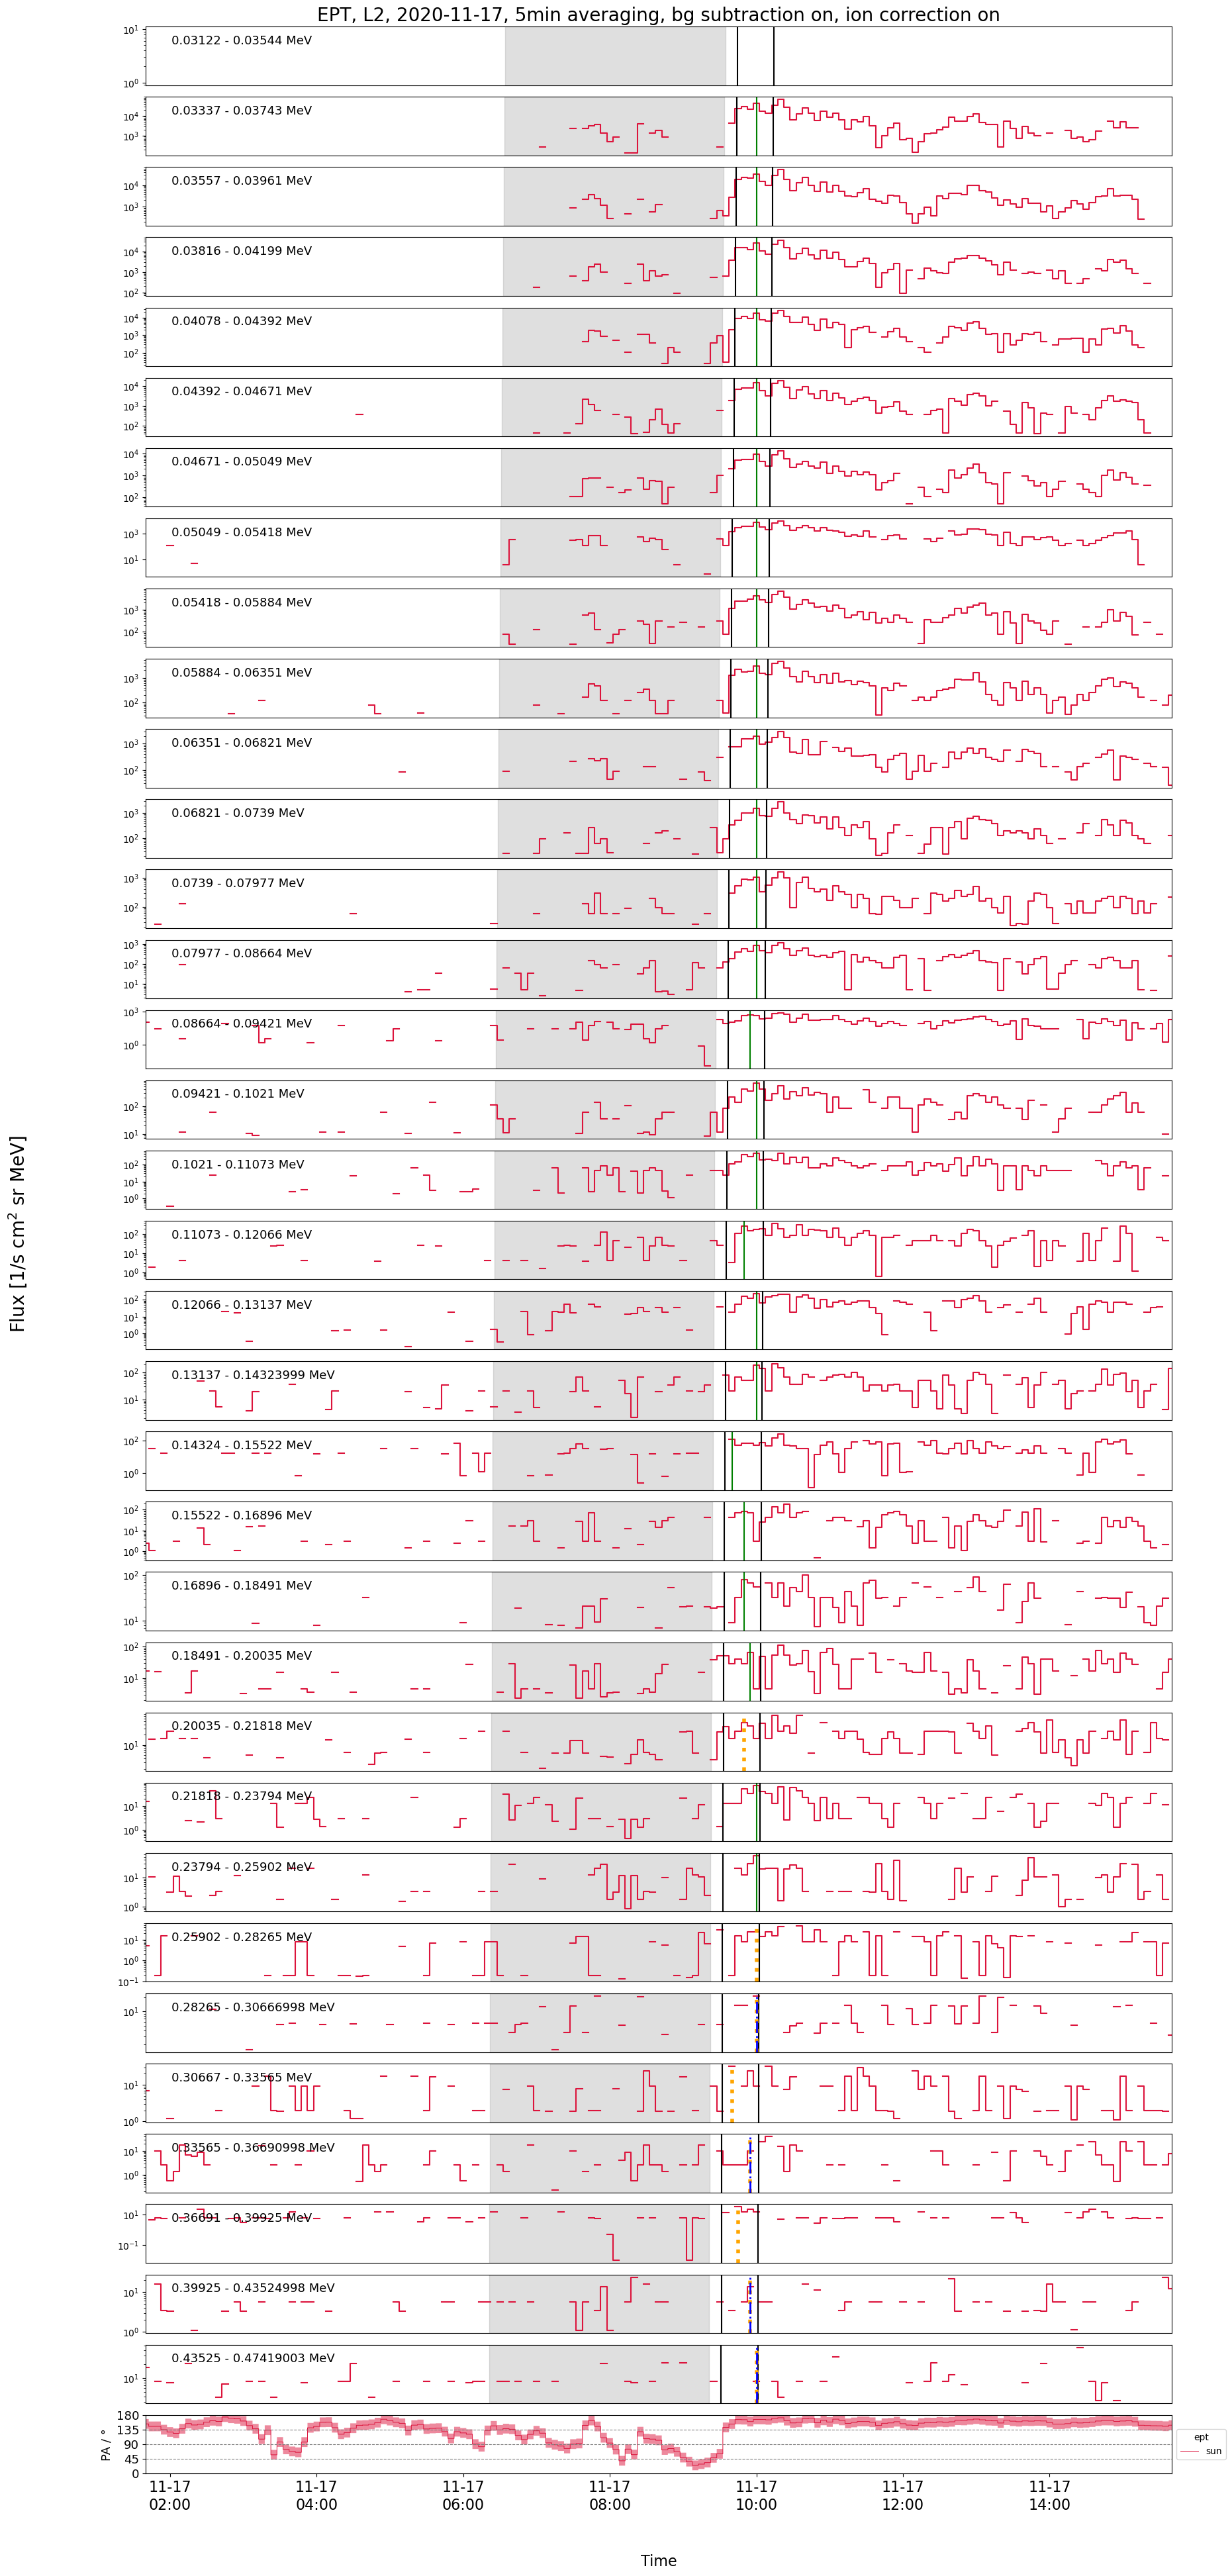

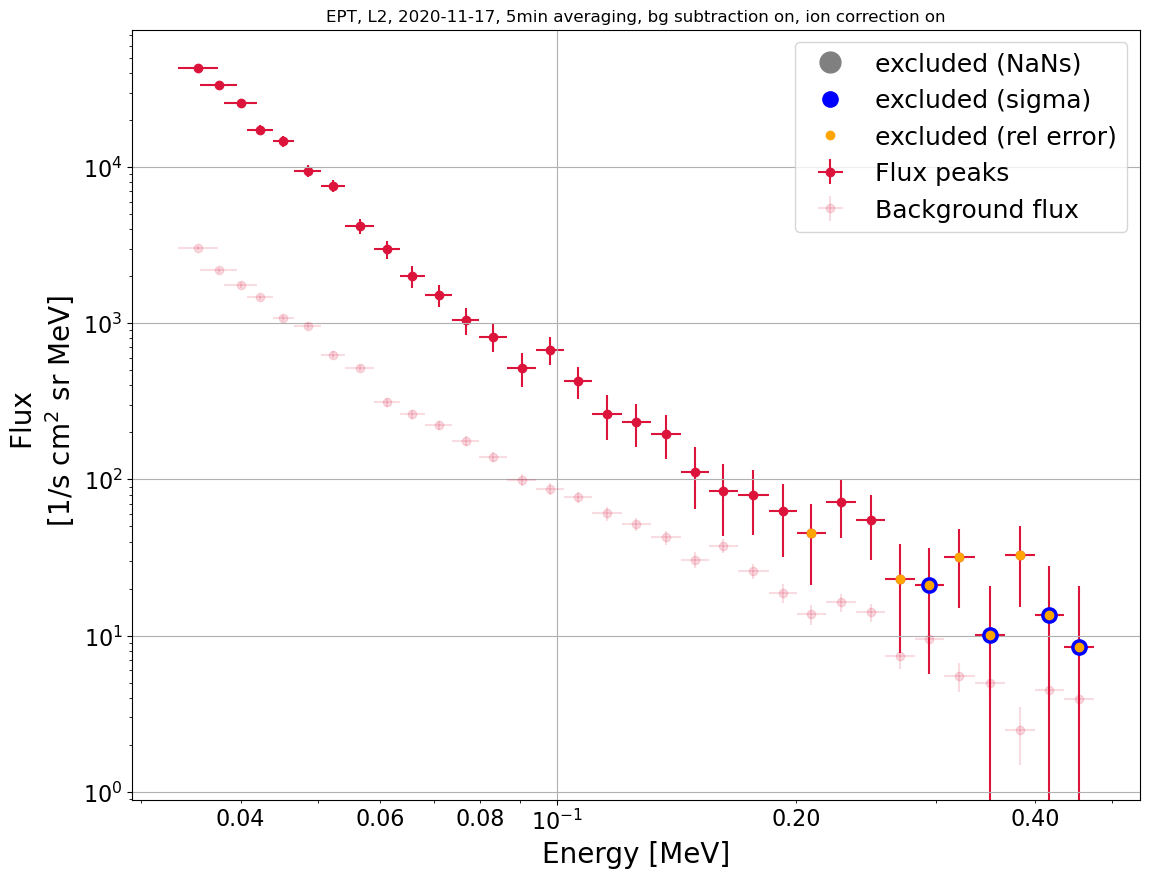

In [72]:
if ept:
    ion_b = ion_correction    
    data_ept = extract_electron_data(df_electrons_ept, energies_ept, plot_start, plot_end, t_inj, bgstart = bg_start, 
                                     bgend = bg_end, bg_distance_from_window = bg_distance_from_window, bg_period = bg_period, 
                                     travel_distance = travel_distance, travel_distance_second_slope=travel_distance_second_slope, 
                                     fixed_window=fixed_window, instrument = 'ept', data_type = 'l2', averaging=averaging, masking=True, 
                                     ion_conta_corr=ion_b, df_protons = df_protons_ept)

    
    if plot_pa:
        mag_srf = mag_srf.resample(averaging).mean()
        coverage = calc_pa_coverage('ept', mag_srf)
    else:
        coverage = None

    if saving: write_to_csv(data_ept, path=path_to_folder)
    bg_b = bg_subtraction
    plot_channels(data_ept, bg_subtraction=bg_b, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'ept', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, viewing = direction)
    bg_b = bg_subtraction
    plot_spectrum_peak(data_ept, bg_subtraction=bg_b, path=plot_path, savefig=saving, sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, direction = direction) 
    #plot_spectrum_average(data_ept, bg_subtraction=bg_b, path=path_to_folder, savefig=saving, frac_nan_threshold=frac_nan_threshold)      


## HET

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:815: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_electron_uncertainties['Electron_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')


Calculating PA coverage for het...


100%|██████████| 576/576 [00:00<00:00, 11041.22it/s]


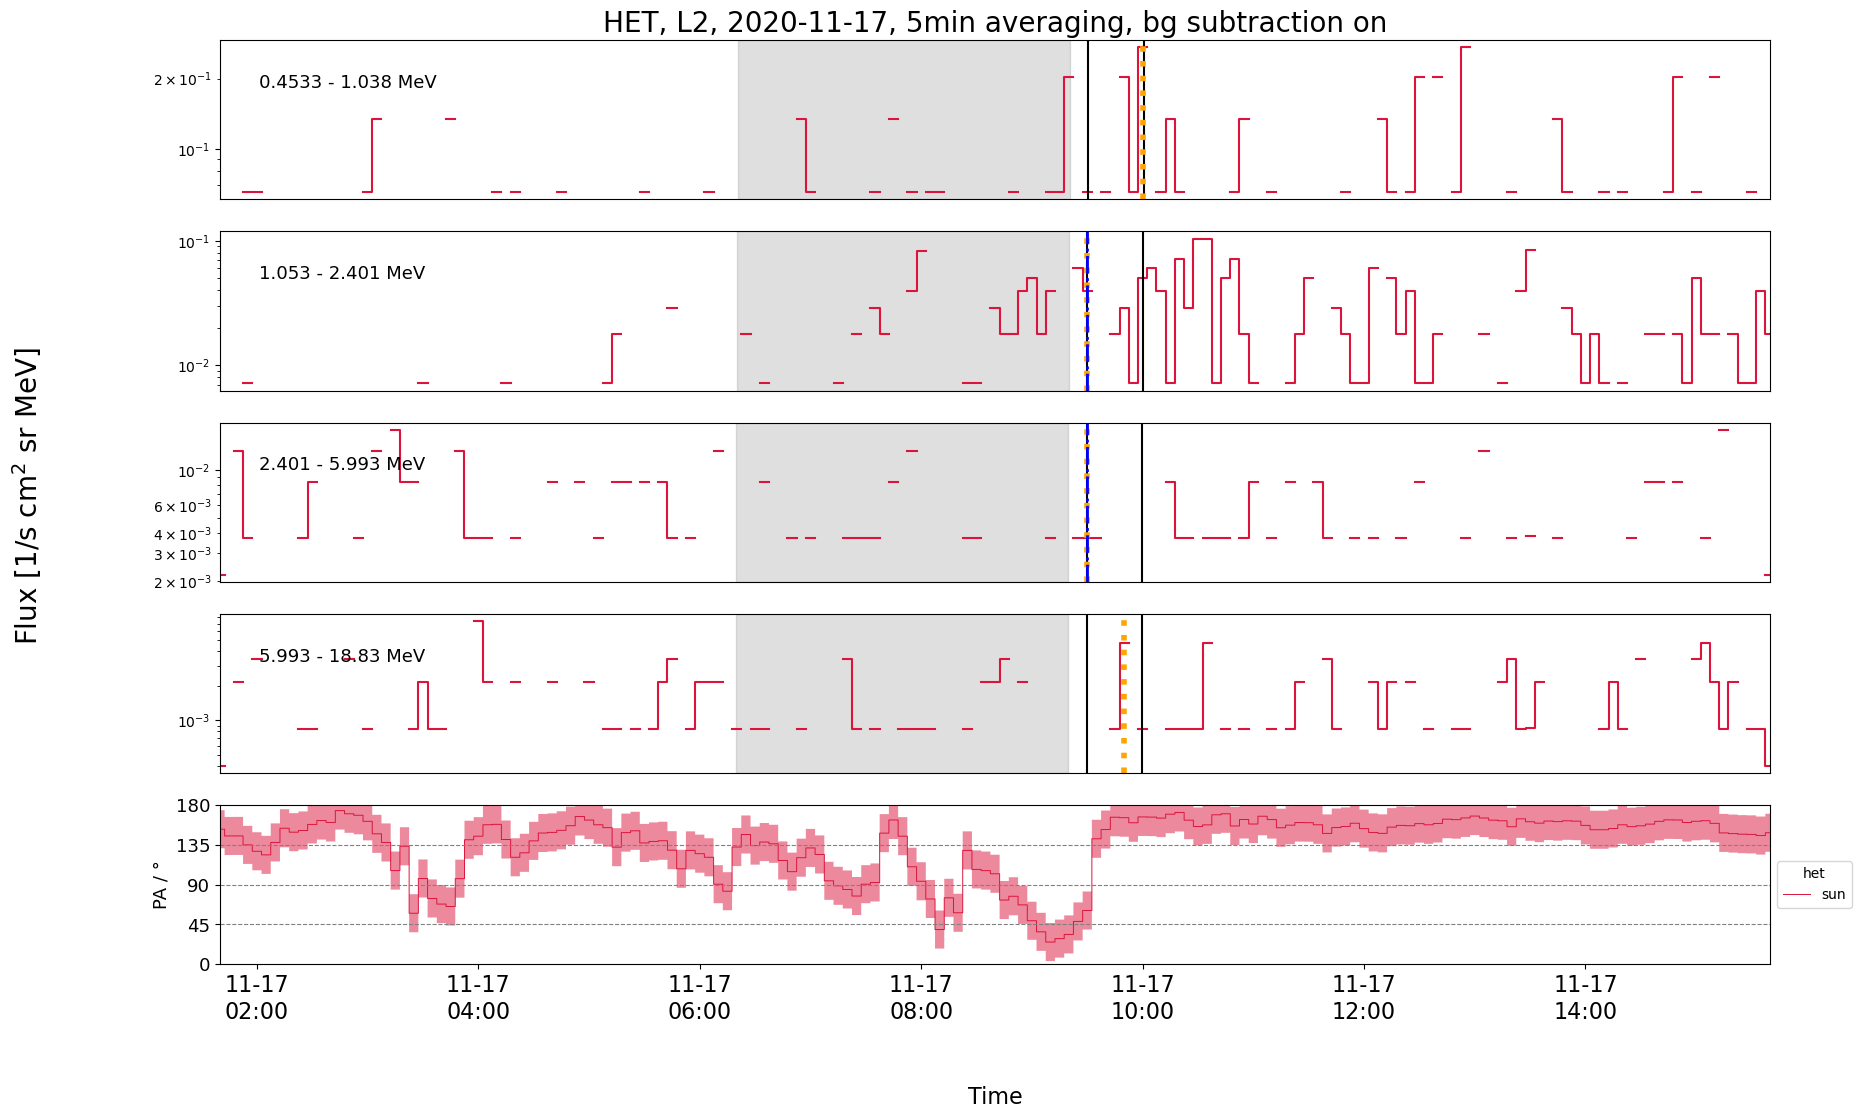

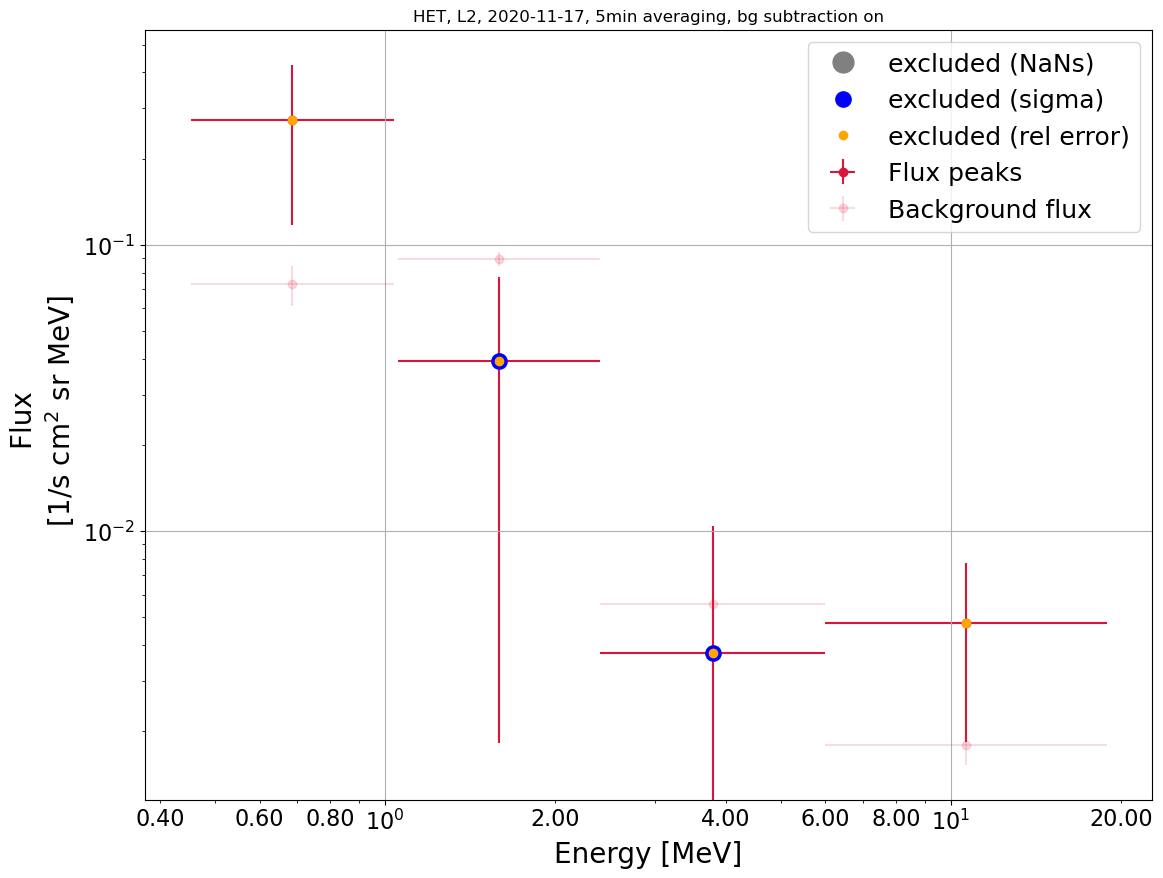

In [73]:
if het:
    data_het = extract_electron_data(df_electrons_het, energies_het, plot_start, plot_end, t_inj, 
                                     bgstart = bg_start, bgend = bg_end,  bg_distance_from_window = bg_distance_from_window,
                                     bg_period = bg_period, travel_distance = travel_distance, 
                                     travel_distance_second_slope = travel_distance_second_slope, 
                                     fixed_window = fixed_window, instrument='het', data_type='l2', 
                                     averaging=averaging, df_protons = df_protons_het)

    if plot_pa:
        mag_srf = mag_srf.resample(averaging).mean()
        coverage = calc_pa_coverage('het', mag_srf)

    if saving: write_to_csv(data_het, path=path_to_folder)
    bg_b = bg_subtraction
    plot_channels(data_het, bg_subtraction=bg_b, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'het', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, viewing = direction)
    bg_b = bg_subtraction
    plot_spectrum_peak(data_het, bg_subtraction=bg_b, path=plot_path, savefig=saving, sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, direction = direction)


## FIT

In [74]:
c1_guess = 1000
g1_guess = -1.9
g2_guess = -2.5
g3_guess = -4.
alpha_guess = 10.
beta_guess = 10.
break_guess_low = 0.6
break_guess_high = 1.2
cut_guess = 1.2

fit_to = 'peak'

e_min = None
e_max = None

which_fit = 'broken'
detailed_legend = True

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:43: RuntimeWarning: invalid value encountered in power
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:43: RuntimeWarning: overflow encountered in double_scalars
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:43: RuntimeWarning: invalid value encountered in divide
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:43: RuntimeWarning: invalid value encountered in double_scalars
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
broken


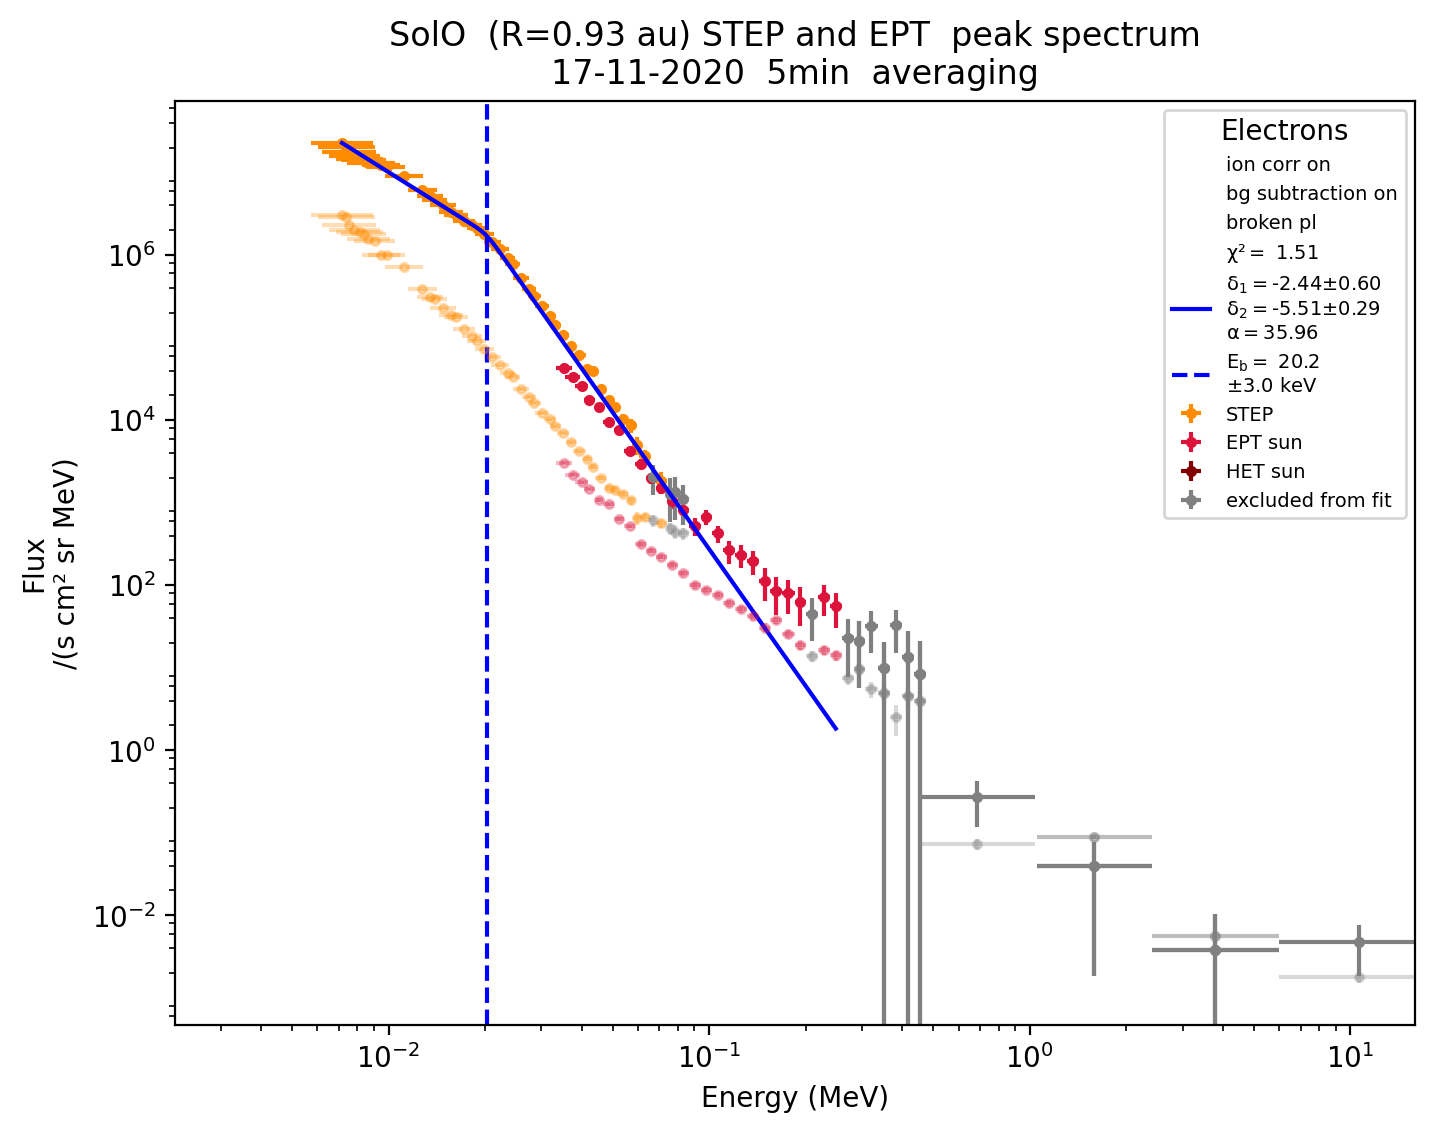

In [75]:
FIT_DATA(path_to_folder, date, averaging = averaging, fit_type= fit_type, step = step, ept = ept, het = het, 
         which_fit = which_fit, sigma = sigma, rel_err = rel_err, frac_nan_threshold = frac_nan_threshold, fit_to = fit_to, 
         e_min = e_min, e_max = e_max, g1_guess = g1_guess, g2_guess = g2_guess, g3_guess = g3_guess, c1_guess = c1_guess, 
         alpha_guess = alpha_guess, beta_guess = beta_guess, break_guess_low = break_guess_low, break_guess_high = break_guess_high, cut_guess = cut_guess, 
         use_random = use_random, iterations = random_iterations, leave_out_1st_het_chan = leave_out_1st_het_chan, shift_step_data = shift_step_data, 
         shift_factor = shift_factor, save_fig = saving, save_pickle = False, save_fit_variables = saving, save_fitrun = saving, legend_details = detailed_legend, 
         ion_correction = ion_correction, bg_subtraction = bg_subtraction, fit_to_separate_folder = plot_n_data_folders)


In [76]:
path

'/home/annafed/Documents/STIX_EPD_event_analysis/'

In [77]:
#if averaging<1.:
 #   averaging = str(int(averaging*60))+'s'
#else:
 #   averaging = str(averaging)+'min'

if save_fit_run_variables_to_separate_folders:
    fit_var_file = date_folder+'-fit-result-variables_'+fit_type+'-'+fit_to+'-'+which_fit+'-l2-'+averaging+'-'+direction+'.csv'
    run_var_file = date_folder+'-all-fit-variables_'+fit_type+'-'+fit_to+'-'+which_fit+'-l2-'+averaging+'-'+direction+'.csv'

    save_fit_and_run_variables_to_separate_folders(path, date_folder, fit_var_file, run_var_file)
    